In [1]:
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Concatenate
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import wget
import zipfile as zf

%matplotlib inline

/home/ubuntu/anaconda3/envs/tf/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
TRAIN_DIR = './train'
TEST_DIR = './test'
TRAIN_ZFILE = 'train.zip'
TEST_ZFILE = 'test.zip'

In [3]:
def may_download_or_extract(url, zfile, zdir):
    
    if not os.path.isdir(zdir):
        if not zf.is_zipfile(zfile):
            wget.download(url, zfile)
            
        with zf.ZipFile(zfile) as my_zip:
                my_zip.extractall()            

In [4]:
train_url = ''
test_url = ''

with open('data_url.txt', 'r') as f:
    train_url = f.readline()
    test_url = f.readline()

may_download_or_extract(train_url, TRAIN_ZFILE, TRAIN_DIR)
may_download_or_extract(test_url, TEST_ZFILE, TEST_DIR)

In [5]:
def load_train_images(imgs_dir):
    
    img_names = np.array(os.listdir(imgs_dir))
    n_imgs = len(img_names)
    
    x = np.zeros((n_imgs, 299, 299, 3), dtype=np.uint8)
    y = np.zeros((n_imgs,), dtype=np.bool)
    
    # shuffle the images    
    indices = np.arange(len(img_names))
    np.random.shuffle(indices)
    img_names = img_names[indices]
    
    for i, img_name in tqdm(enumerate(img_names)):
        img_path = os.path.join(imgs_dir, img_name)
        img = cv2.resize(cv2.imread(img_path), dsize=(299, 299))
        x[i] = img
        if img_name.startswith('cat'):
            y[i] = False
        else:
            y[i] = True
    
    return x, y

In [6]:
def load_test_images(imgs_dir):
    
    img_names = np.array(os.listdir(imgs_dir))
    n_imgs = len(img_names)
    
    ids = np.zeros((n_imgs,), dtype='<U6')
    x = np.zeros((n_imgs, 299, 299, 3), dtype=np.uint8)
    
    for i, img_name in tqdm(enumerate(img_names)):
        img_path = os.path.join(imgs_dir, img_name)
        img = cv2.resize(cv2.imread(img_path), dsize=(299, 299))
        ids[i] = img_name[:-4]
        x[i] = img
    
    return ids, x

In [7]:
def preprocess_input(x):
    
    x = x.astype(np.float32)
    x /= 127.5
    x -= 1.
    
    return x

In [8]:
#示例图片
def show_img_examples(x, y):    
    
    inds = np.random.randint(len(y),size=12)
    x_examples = x[inds]
    y_examples = y[inds]
    fig = plt.figure(figsize=(20,8))
    
    for i, (img, cls) in enumerate(zip(x_examples, y_examples)):
        a = fig.add_subplot(2, 6, i+1)
        plt.imshow(img)
        a.set_title('dog {:.2f}%'.format(cls*100) if cls>0.5 else 'cat {:.2f}%'.format((1-cls)*100))
    
    plt.show()

In [9]:
def my_model(lr):
    
    input_tensor = Input(shape=(299, 299, 3))
        
    base_model_1 = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    base_model_2 = InceptionV3(input_tensor=input_tensor, include_top=False, weights='imagenet')
        
    x1 = base_model_1.output
    x2 = base_model_2.output
    
    x1 = GlobalAveragePooling2D()(x1)
    x2 = GlobalAveragePooling2D()(x2)
    
    x = Concatenate(axis=-1)([x1, x2])
        
    x = Dense(1024, activation='relu', kernel_initializer='truncated_normal', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
        
    preds = Dense(1, activation='sigmoid', kernel_initializer='truncated_normal', kernel_regularizer=l2(0.001))(x)
    
    # this is the model we will train
    model = Model(inputs=input_tensor, outputs=preds)
        
    # freeze all base model layers
    for layer in base_model_1.layers:
        layer.trainable = False
        
    for layer in base_model_2.layers:
        layer.trainable = False
        
    model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [10]:
x_train, y_train = load_train_images(TRAIN_DIR)

25000it [03:24, 122.53it/s]


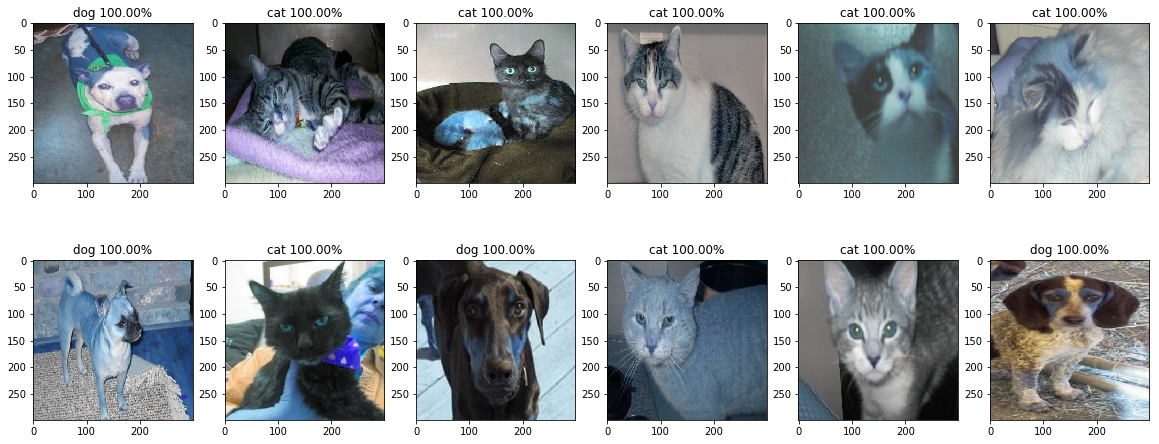

In [11]:
show_img_examples(x_train, y_train)

In [12]:
x_train = preprocess_input(x_train)

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

val_datagen = ImageDataGenerator()

train_gen = train_datagen.flow(x_train[:20000], y_train[:20000], batch_size=128, seed=0)
val_gen = val_datagen.flow(x_train[20001:], y_train[20001:], batch_size=128, shuffle=False)

In [13]:
model = my_model(0.0001)
#model.summary()

In [14]:
# training
hist = model.fit_generator(
    train_gen,
    steps_per_epoch=157,
    epochs=10,
    validation_data=val_gen,
    validation_steps=40)

model.save('my_model.h5')

Epoch 1/10
157/157 [==============================] - 462s 3s/step - loss: 7.3389 - acc: 0.9511 - val_loss: 6.3252 - val_acc: 0.9844
Epoch 2/10
157/157 [==============================] - 399s 3s/step - loss: 5.5348 - acc: 0.9784 - val_loss: 4.7779 - val_acc: 0.9888
Epoch 3/10
157/157 [==============================] - 399s 3s/step - loss: 4.1952 - acc: 0.9809 - val_loss: 3.6454 - val_acc: 0.9854
Epoch 4/10
157/157 [==============================] - 400s 3s/step - loss: 3.1995 - acc: 0.9824 - val_loss: 2.7976 - val_acc: 0.9860
Epoch 5/10
157/157 [==============================] - 400s 3s/step - loss: 2.4666 - acc: 0.9831 - val_loss: 2.1639 - val_acc: 0.9882
Epoch 6/10
157/157 [==============================] - 398s 3s/step - loss: 1.9328 - acc: 0.9821 - val_loss: 1.7419 - val_acc: 0.9772
Epoch 7/10
157/157 [==============================] - 402s 3s/step - loss: 1.5297 - acc: 0.9828 - val_loss: 1.3994 - val_acc: 0.9776
Epoch 8/10
157/157 [==============================] - 399s 3s/step - 

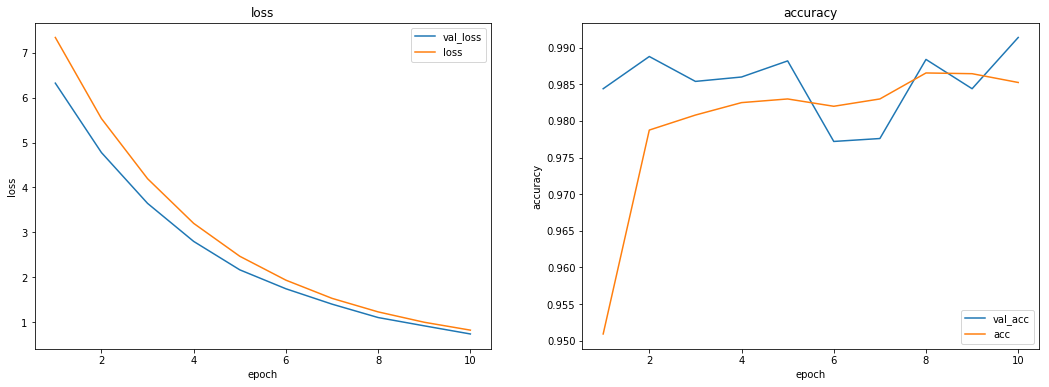

In [15]:
his = hist.history
epochs = list(range(1, 11))
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.title('loss')
plt.plot(epochs, his['val_loss'], label='val_loss')
plt.plot(epochs, his['loss'], label='loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(122)
plt.title('accuracy')
plt.plot(epochs, his['val_acc'], label='val_acc')
plt.plot(epochs, his['acc'], label='acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

plt.show()

In [16]:
# from keras.models import load_model
# model = load_model('my_model.h5')

ids, x_test_ori = load_test_images(TEST_DIR)
#test_x = np.array(x_test)
x_test = preprocess_input(x_test_ori)

preds = model.predict(x_test, batch_size=128)

12500it [01:34, 132.55it/s]


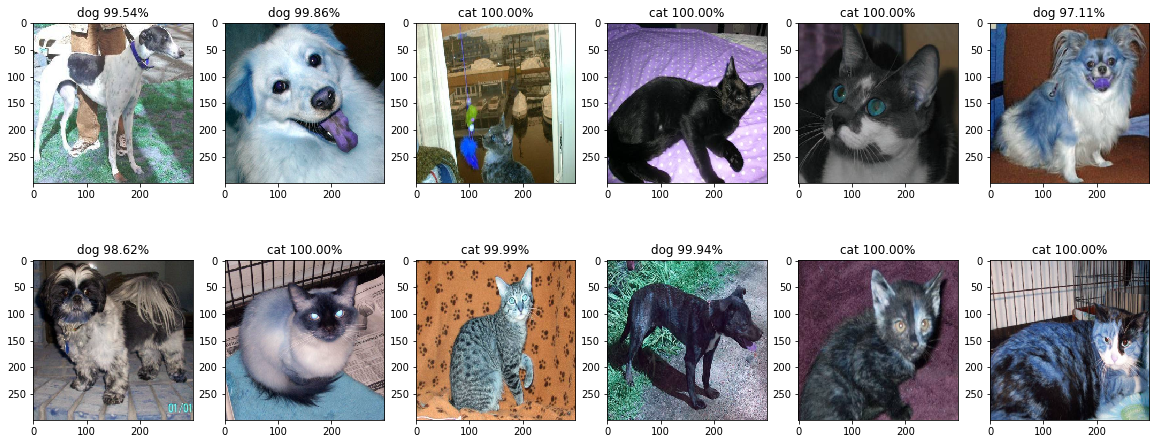

In [17]:
show_img_examples(x_test_ori, preds[:,0])

In [18]:
# save predictions as a csv file
import pandas as pd
dic = {'id':ids, 'label':preds[:,0].clip(min=0.02, max=0.98)}
df = pd.DataFrame(dic)
df.to_csv('submission.csv', index=False)

In [19]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 149, 149, 32) 96          conv2d_5[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_5[0][0]      
__________________________________________________________________________________________________
conv2d_6 (

In [4]:
m1 = Model(inputs=model.input, outputs=model.get_layer('block14_sepconv2_act').output)
m2 = Model(inputs=model.input, outputs=model.get_layer('mixed10').output)

weight1 = model.get_layer('dense_1').get_weights()[0]
weight2 = model.get_layer('dense_2').get_weights()[0]

In [5]:
inds = np.random.randint(len(x_test_ori),size=12)
x_ori_examples = x_test_ori[inds]
x_examples = x_test[inds]
y_examples = preds[inds]

preds_m1 = m1.predict(x_examples)
preds_m2 = m2.predict(x_examples)

cams1 = np.matmul(np.matmul(preds_m1, weight1[:2048]), weight2)
cams2 = np.matmul(np.matmul(preds_m2, weight1[2048:]), weight2)

fig = plt.figure(figsize=(20,8))

for i, (img, cam1, cam2, cls) in enumerate(zip(x_ori_examples, cams1, cams2, y_examples)):
    
    a = fig.add_subplot(2, 6, i+1)
    
    cam1 = cv2.resize(cam1, dsize=(299,299))
    cam2 = cv2.resize(cam2, dsize=(299,299))
    cam = cam1 + cam2
    
    cam = (cam - cam.min()) / (cam.max() - cam.min()) * 255
    cam = cam.astype(np.uint8)
    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    heatmap[cam < 64] = 0
    
    out = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)
        
    a.set_title('dog {:.2f}%'.format(cls*100) if cls>0.5 else 'cat {:.2f}%'.format((1-cls)*100))
    plt.imshow(out[:,:,::-1])

plt.show()